# **데이터베이스 Call 테스트**
- 테스트 테이블 생성

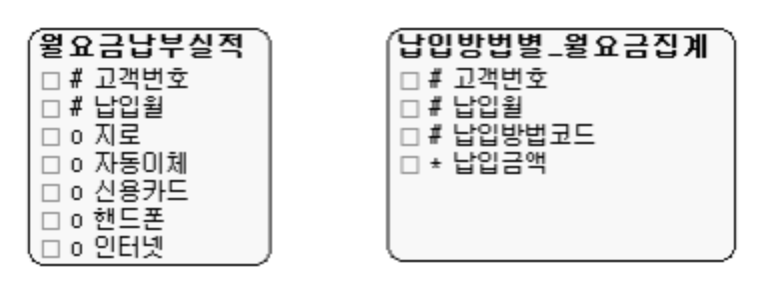



```sql
CREATE TABLE 월요금납부실적
AS
SELECT TO_CHAR(OBJECT_ID) 고객번호
     , '200903' 납입월
     , round(dbms_random.value(1000, 10000), -2) 지로
     , round(dbms_random.value(1000, 10000), -2) 자동이체
     , round(dbms_random.value(1000, 10000), -2) 신용카드
     , round(dbms_random.value(1000, 10000), -2) 핸드폰
     , round(dbms_random.value(1000, 10000), -2) 인터넷
FROM   ALL_OBJECTS
WHERE ROWNUM <= 30000;

CREATE TABLE 납입방법별_월요금집계 (
  고객번호      NUMBER
, 납입월        VARCHAR2(6)
, 납입방법코드  VARCHAR2(1)
, 납입금액       NUMBER
) ;
```



[예시1] 기간계 시스템을 정보계 시스템으로 가져오기 위한 ETL 배치 프로그램이 필요하다고 가정 - PL/SQL 수행
'월요금납부실적' 테이블은 고객별 납입방법별 납입요금을 컬럼값으로 입력한다.
기간계 시스템
'납입방법별_월요금집계' 테이블은 납입요금을 납입방법코드별로 하나의 레코드로 입력한다.
정보계 시스템 > 납입방법코드를 PK로




```sql
        DECLARE
          CURSOR C(INPUT_MONTH VARCHAR2) IS
            SELECT 고객번호, 납입월, 지로, 자동이체, 신용카드, 핸드폰, 인터넷
            FROM   월요금납부실적  
            WHERE 납입월 = INPUT_MONTH;

          REC C%ROWTYPE;
          LTYPE VARCHAR2(1);
        BEGIN
          OPEN C('200903');

          LOOP
            FETCH C INTO REC;
            EXIT WHEN C%NOTFOUND;

            IF REC.지로 > 0 THEN
              LTYPE := 'A';
              INSERT INTO 납입방법별_월요금집계
                    (고객번호, 납입월, 납입방법코드, 납입금액)  
              VALUES(REC.고객번호, REC.납입월, LTYPE, REC.지로);
            END IF;

            IF REC.자동이체 > 0 THEN
              LTYPE := 'B';
              INSERT INTO 납입방법별_월요금집계
                    (고객번호, 납입월, 납입방법코드, 납입금액)  
              VALUES(REC.고객번호, REC.납입월, LTYPE, REC.자동이체);
            END IF; .......
          END LOOP;

          CLOSE C;
         END;
```

- 결과

```sql
SELECT 고객번호, 납입월, 지로, 자동이체, 신용카드, 핸드폰, 인터넷
FROM 월요금납부실적
WHERE 납입월 = :B1


call     count       cpu    elapsed       disk      query    current        rows
------- ------  -------- ---------- ---------- ---------- ----------  ----------
Parse        1      0.00       0.00          0          0          0           0
Execute      1      0.00       0.03          0          1          0           0
Fetch    30001      0.32       0.25          0      30004          0       30000
------- ------  -------- ---------- ---------- ---------- ----------  ----------
total    30003      0.32       0.29          0      30005          0       30000

Misses in library cache during parse: 1
Misses in library cache during execute: 1
Optimizer mode: ALL_ROWS
Parsing user id: 41     (recursive depth: 1)

Rows     Row Source Operation
-------  ---------------------------------------------------
  30000  TABLE ACCESS FULL 월요금납부실적 (cr=30004 pr=0 pw=0 time=150156 us)
********************************************************************************
  
INSERT INTO 납입방법별_월요금집계 (고객번호, 납입월, 납입방법코드, 납입금액)
VALUES
(:B4 , :B3 , :B2 , :B1 )


call     count       cpu    elapsed       disk      query    current        rows
------- ------  -------- ---------- ---------- ---------- ----------  ----------
Parse        5      0.00       0.00          0          0          0           0
Execute 150000      3.38       3.14          0       2440     162387      150000
Fetch        0      0.00       0.00          0          0          0           0
------- ------  -------- ---------- ---------- ---------- ----------  ----------
total   150005      3.38       3.14          0       2440     162387      150000

Misses in library cache during parse: 1
Misses in library cache during execute: 1
Optimizer mode: ALL_ROWS
Parsing user id: 41     (recursive depth: 1)
```

- 총소요시간 : 1,377 msc
- 데이터베이스 call : 180,008번
- 처리해야 할 월요금납부실적이 100만 건이면 최대 200만 번의 데이터베이스 Call이 발생.
  - 이 테이블에 대한 Fetch Call이 100만 번 일어남
  - 납입방법별_월요금집계 테이블로의 insert를 위한 Execute Call이 최대 100만번이 일어남.
- PL/SQL문으로 코딩했기 때문에 네트워크 트래픽 없는 Recursive Call이므로 제법 빠르게 수행.



[예시2] 기간계 시스템을 정보계 시스템으로 가져오기 위한 ETL 배치 프로그램이 필요하다고 가정 - JAVA 프로그램 수행
'월요금납부실적' 테이블은 고객별 납입방법별 납입요금을 컬럼 값으로 입력한다.
기간계 시스템
'납입방법별_월요금집계' 테이블은 납입요금을 납입방법코드별로 하나의 레코드로 입력한다.
정보계 시스템 > 납입방법코드를 PK로



```sql
public class JavaLoopQuery{
  public static void insertData( Connection con , String param1 , String param2 , String param3 , long param4) throws Exception{
    String SQLStmt = ""INSERT INTO 납입방법별_월요금집계  ""  + ""(고객번호, 납입월, 납입방법코드, 납입금액) "" + ""VALUES(?, ?, ?, ?)"";
    PreparedStatement st = con.prepareStatement(SQLStmt);
    st.setString(1, param1);
    st.setString(2, param2);
    st.setString(3, param3);
    st.setLong(4, param4);
    st.execute();
    st.close();  }

  public static void execute(Connection con, String input_month)  
  throws Exception {
    String SQLStmt = ""SELECT 고객번호, 납입월"" + "", 지로, 자동이체, 신용카드, 핸드폰, 인터넷 ""+ ""FROM 월요금납부실적 "" + ""WHERE  납입월 = ?"";
    PreparedStatement stmt = con.prepareStatement(SQLStmt);
    stmt.setString(1, input_month);
    ResultSet rs = stmt.executeQuery();  -- (2-1)
    while(rs.next()){
      String 고객번호 = rs.getString(1);
      String 납입월 = rs.getString(2);
      long 지로 = rs.getLong(3);
      long 자동이체 = rs.getLong(4);
      long 신용카드 = rs.getLong(5);
      long 핸드폰 = rs.getLong(6);
      long 인터넷 = rs.getLong(7);
      if(지로 > 0)     insertData (con, 고객번호, 납입월, ""A"", 지로); -- (2-2)
      if(자동이체 > 0) insertData (con, 고객번호, 납입월, ""B"", 자동이체);
      if(신용카드 > 0) insertData (con, 고객번호, 납입월, ""C"", 신용카드);
      if(핸드폰 > 0)   insertData (con, 고객번호, 납입월, ""D"", 핸드폰);
      if(인터넷 > 0)   insertData (con, 고객번호, 납입월, ""E"", 인터넷);
    }
    rs.close();
    stmt.close();
  }

  public static void main(String[] args) throws Exception{
    long btm = System.currentTimeMillis();
    Connection con = getConnection();
    execute(con, ""200903"");
    System.out.println(""elapsed time : "" + (System.currentTimeMillis() - btm));
    releaseConnection(con); }
```

- 결과

```sql
SELECT 고객번호, 납입월     , 지로, 자동이체, 신용카드, 핸드폰, 인터넷
FROM
   월요금납부실적 WHERE  납입월 = :1


call     count       cpu    elapsed       disk      query    current        rows
------- ------  -------- ---------- ---------- ---------- ----------  ----------
Parse        1      0.00       0.00          0          0          0           0
Execute      1      0.00       0.00          0          0          0           0
Fetch     3001      0.14       0.27          0       3121          0       30000
------- ------  -------- ---------- ---------- ---------- ----------  ----------
total     3003      0.14       0.27          0       3121          0       30000

Misses in library cache during parse: 0
Optimizer mode: ALL_ROWS
Parsing user id: 41  

Rows     Row Source Operation
-------  ---------------------------------------------------
  30000  TABLE ACCESS FULL 월요금납부실적 (cr=3121 pr=0 pw=0 time=60062 us)


Elapsed times include waiting on following events:
  Event waited on                             Times   Max. Wait  Total Waited
  ----------------------------------------   Waited  ----------  ------------
  SQL*Net message to client                    3002        0.00          0.00
  SQL*Net message from client                  3002        0.06          0.43
********************************************************************************

INSERT INTO 납입방법별_월요금집계  (고객번호, 납입월, 납입방법코드, 납입금액)
VALUES
(:1, :2, :3, :4)


call     count       cpu    elapsed       disk      query    current        rows
------- ------  -------- ---------- ---------- ---------- ----------  ----------
Parse   150000      1.35       1.26          0          0          0           0
Execute 150000      8.31       9.56          2     150130     746331      150000
Fetch        0      0.00       0.00          0          0          0           0
------- ------  -------- ---------- ---------- ---------- ----------  ----------
total   300000      9.66      10.82          2     150130     746331      150000

Misses in library cache during parse: 1
Misses in library cache during execute: 1
Optimizer mode: ALL_ROWS
Parsing user id: 41  

Elapsed times include waiting on following events:
  Event waited on                             Times   Max. Wait  Total Waited
  ----------------------------------------   Waited  ----------  ------------
  SQL*Net message to client                  150001        0.00          0.10
  SQL*Net message from client                150001        0.47         17.10
  db file sequential read                         2        0.00          0.00
  log file sync                              149996        0.18        828.75
  latch: messages                                 6        0.00          0.00
  latch: library cache                            1        0.01          0.01
  log file switch completion                      1        0.19          0.19
```

- 어플리케이션에선 문제가 더 심각해짐.
- 총소요시간 : 942,519 msc
- 데이터베이스 call : 303,000번
  - select 문에서 Fetch Call이 앞에서보다 1/10 수준으로 준 것은 JAVA에서 FetchSize 기본 설정이 10으로 설정되었기 때문.
  - insert문은 애플리케이션 커서 캐싱 기법을 사용하지 않았으므로 Execute Call과 같은 횟수만큼 Parse Call 발생.

- 중요한것은 순수하게 서버에서 실행된 시간은 10여초에 불과.
  - 네트워크구간에서 소비한 시간
  - 데이터베이스Call이 발생할 때마다 매번 OS로부터 CPU와 메모리 리소스를 할당받으려고 소비한 시간의 합으로 훨씬 더 큼.
- 이는 User Call이 Recursive Call에 비해 더 심각한 부하를 일으키는 이유를 명실공히 보여줌.

# **데이터베이스 CALL 성능 개선하기**

**개선 (1) One-SQL 이용하기(1)**

- One-SQL로 통합하고 수행하면 1초가 채 걸리지 않는다.




```sql
INSERT INTO 납입방법별_월요금집계(납입월,고객번호,납입방법코드,납입금액)
SELECT x.납입월, x.고객번호 , CHR(64 + Y.NO) 납입방법코드 , DECODE(Y.NO, 1, 지로, 2, 자동이체, 3, 신용카드, 4, 핸드폰, 5, 인터넷)
FROM   월요금납부실적 x
   ,(SELECT LEVEL NO FROM DUAL CONNECT BY LEVEL <= 5) y
WHERE x.납입월 = '200903'
AND   y.NO IN (  
      DECODE(지로, 0, NULL, 1)
    , DECODE(자동이체, 0, NULL, 2)
    , DECODE(신용카드, 0, NULL, 3)  
    , DECODE(핸드폰, 0, NULL, 4)  
    , DECODE(인터넷, 0, NULL, 5)   ) ;
```

- 결과
 - 데이터양이 많을 때는 소트 머지 조인 또는 해시 조인으로 유도하기 위한 약간의 튜닝이 필요

```sql

================================================================================
Call     Count CPU Time Elapsed Time       Disk      Query    Current       Rows
------- ------ -------- ------------ ---------- ---------- ---------- ----------
Parse        1    0.000        0.000          0          0          0          0
Execute      1    1.190        1.304          0       1590       3835     150000
Fetch        0    0.000        0.000          0          0          0          0
------- ------ -------- ------------ ---------- ---------- ---------- ----------
Total        2    1.190        1.304          0       1590       3835     150000

Misses in library cache during parse: 0
Optimizer goal: FIRST_ROWS
Parsing user: IBS_ADM (ID=41)
================================================================================
Rows     Row Source Operation
-------  ---------------------------------------------------
    0  STATEMENT
150000   NESTED LOOPS  (cr=710 pr=0 pw=0 time=600157 us)
    5    VIEW  (cr=0 pr=0 pw=0 time=96 us)
    5     CONNECT BY WITHOUT FILTERING (cr=0 pr=0 pw=0 time=87 us)
    1      FAST DUAL  (cr=0 pr=0 pw=0 time=4 us)
150000    TABLE ACCESS FULL 월요금납부실적 (cr=710 pr=0 pw=0 time=450321 us)
================================================================================
```



**개선 (2) 조인 기법을 유도한 튜닝**

- 데이터양이 많을 때는 소트 머지 조인 또는 해시 조인으로 유도하기 위한 약간의 튜닝이 필요.



```sql
INSERT INTO 납입방법별_월요금집계(납입월,고객번호,납입방법코드,납입금액)
SELECT */*+ USE_MERGE(X Y) NO_EXPAND NO_MERGE(X) */* x.납입월, x.고객번호
   , CHR(64 + Y.NO) 납입방법코드
   , DECODE(Y.NO, 1, 지로, 2, 자동이체, 3, 신용카드, 4, 핸드폰, 5, 인터넷)
FROM  (SELECT 1 DUMMY,납입월,고객번호,지로,자동이체,신용카드,핸드폰,인터넷  
     FROM   월요금납부실적
     WHERE  납입월 = '200903') x
   ,(SELECT 1 DUMMY, LEVEL NO FROM DUAL CONNECT BY LEVEL <= 5) y
WHERE x.DUMMY = y.DUMMY
AND   y.NO IN (  
      DECODE(지로, 0, NULL, 1)
    , DECODE(자동이체, 0, NULL, 2)
    , DECODE(신용카드, 0, NULL, 3)  
    , DECODE(핸드폰, 0, NULL, 4)  
    , DECODE(인터넷, 0, NULL, 5)  
) ;   
```

- 결과
  - 총 소요시간 : 1초안밖
  - 다음절에 나오는 Array Pocessing 기법을 활용하면, JAVA 같은 프로그램에서도 네트워크 트래픽을 획기적으로 줄여줘 굳이 One-SQL로 작성하지 않더라도 성능개선 효과를 얻을 수 있음.

```sql
================================================================================
Call     Count CPU Time Elapsed Time       Disk      Query    Current       Rows
------- ------ -------- ------------ ---------- ---------- ---------- ----------
Parse        1    0.000        0.000          0          0          0          0
Execute      1    1.470        1.550          0       1037       3778     150000
Fetch        0    0.000        0.000          0          0          0          0
------- ------ -------- ------------ ---------- ---------- ---------- ----------
Total        2    1.470        1.550          0       1037       3778     150000

Misses in library cache during parse: 0
Optimizer goal: FIRST_ROWS
Parsing user: IBS_ADM (ID=41) "
"       Rows     Row Source Operation
-------  ---------------------------------------------------
      0  STATEMENT
 150000   MERGE JOIN  (cr=142 pr=0 pw=0 time=1004484 us)
      5    SORT JOIN (cr=0 pr=0 pw=0 time=115 us)
      5     VIEW  (cr=0 pr=0 pw=0 time=70 us)
      5      CONNECT BY WITHOUT FILTERING (cr=0 pr=0 pw=0 time=55 us)
      1       FAST DUAL  (cr=0 pr=0 pw=0 time=4 us)
 150000    FILTER  (cr=142 pr=0 pw=0 time=854395 us)
 150000     SORT JOIN (cr=142 pr=0 pw=0 time=254934 us)
  30000      VIEW  (cr=142 pr=0 pw=0 time=60074 us)
  30000       TABLE ACCESS FULL 월요금납부실적 (cr=142 pr=0 pw=0 time=72 us)
================================================================================
```



**개선 (3) One-SQL 이용하기(2)**

- "납입방법별_월요금집계" 테이블을 읽어 "월요금납부실적"을 가공할 때

**잘못된 예시**

```sql
INSERT INTO 월요금납부실적
(고객번호, 납입월, 지로, 자동이체, 신용카드, 핸드폰, 인터넷)
SELECT K.고객번호, '200903' 납입월  , A.납입금액 지로  , B.납입금액 자동이체  
     , C.납입금액 신용카드 , D.납입금액 핸드폰 , E.납입금액 인터넷  
FROM   고객 K
     ,(SELECT 고객번호, 납입금액 FROM 납입방법별_월요금집계
       WHERE  납입월 = '200903'
       AND    납입방법코드 = 'A') A
     ,(SELECT 고객번호, 납입금액 FROM 납입방법별_월요금집계
       WHERE  납입월 = '200903'
       AND    납입방법코드 = 'B') B
     ,(SELECT 고객번호, 납입금액 FROM 납입방법별_월요금집계
       WHERE  납입월 = '200903'
       AND    납입방법코드 = 'C') C
     ,(SELECT 고객번호, 납입금액 FROM 납입방법별_월요금집계
       WHERE  납입월 = '200903'
       AND    납입방법코드 = 'D') D
     ,(SELECT 고객번호, 납입금액 FROM 납입방법별_월요금집계
       WHERE  납입월 = '200903'
       AND    납입방법코드 = 'E') E
WHERE  A.고객번호(+) = K.고객번호
AND    B.고객번호(+) = K.고객번호
AND    C.고객번호(+) = K.고객번호
AND    D.고객번호(+) = K.고객번호
AND    E.고객번호(+) = K.고객번호 ;  
```

**해결 예시**
- I/O효율을 달성하려면 쿼리를 아래와 같이 작성.

```
INSERT INTO 월요금납부실적
(고객번호, 납입월, 지로, 자동이체, 신용카드, 핸드폰, 인터넷)
SELECT 고객번호, 납입월
    , NVL(SUM(DECODE(납입방법코드, 'A', 납입금액)), 0) 지로
    , NVL(SUM(DECODE(납입방법코드, 'B', 납입금액)), 0) 자동이체
    , NVL(SUM(DECODE(납입방법코드, 'C', 납입금액)), 0) 신용카드
    , NVL(SUM(DECODE(납입방법코드, 'D', 납입금액)), 0) 핸드폰
    , NVL(SUM(DECODE(납입방법코드, 'E', 납입금액)), 0) 인터넷
FROM   납입방법별_월요금집계
WHERE  납입월 = '200903'
GROUP BY 고객번호, 납입월 ;
```

